# THIS NOTEBOOK IS DEDICATED TO THE ANALYSIS OF 

# *CoT task*


In [ ]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
import types
import inspect
warnings.filterwarnings("ignore")
import sys, time
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from pylab import *
import matplotlib.backends.backend_pdf
from sklearn.decomposition import KernelPCA

ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
root='/data'
%run UtilityTools.ipynb
%run Animal_Tags.ipynb
%run Lesion_Size.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb
os.chdir(CWD)

# logging.getLogger().setLevel(logging.WARNING)
defaultParam={
            "treadmillRange":[0,65],
            "binSize":0.25,
            "trialOffset":20., #max end of trial, in seconds (position will be cutted)
            "sigmaSmoothPosition":0.1,  #smooth the position
            #"sigmaSmoothPosition":0.33 for pavel dataType
            "sigmaSmoothSpeed":0.3, #smooth the speed
            "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                          #min to correct start, max to correct jumps
            "pawFrequencyRange":[2.,10.],
            "startAnalysisParams":[10,0.2,0.5],
            "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
            "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked


            #parameter to detect end of trial (first position minima)
            "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
            "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
            "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }

print('Done')

# DEFINITIONS

In [ ]:
def plot_event_1on1(root, SessionDict, TaskParamToPlot,
                    ax=None, preSlice=slice(-5,None), postSlice=slice(0,5)):
    
    Plot = True
    if ax is None:
        Plot=False
    
    
    Results,nSessionPre,nSessionPost=event_statistic2(root,
                                                     SessionDict,
                                                     parameter=param,
                                                     redo=False,
                                                     TaskParamToPlot=[TaskParamToPlot])

    data=np.array(list(Results[TaskParamToPlot].values()))
    slicedPreData  = np.ones((data.shape))*np.nan
    slicedPostData = np.ones((data.shape))*np.nan
    
    for row,Dnan in enumerate(data):
        Dpre= Dnan[:nSessionPre][~ np.isnan(Dnan[:nSessionPre])]
        Dpost=Dnan[nSessionPre:][~ np.isnan(Dnan[nSessionPre:])]
        preData =Dpre[preSlice]
        postData=Dpost[postSlice]

        slicedPreData[row,:len(preData)]=preData
        slicedPostData[row,:len(postData)]=postData
    
    y0=np.nanmean(slicedPreData,axis=1)
    y1=np.nanmean(slicedPostData,axis=1)
    
    y=np.array([y0,y1]).T
    
    if Plot:
        #plotting the errorbar
        props={'color':'k','linewidth':1}
        ax.boxplot(x=y,whis=[5,95],
                      positions=[-.5,.5], widths=.3,
                      showcaps=False, showfliers=False,
                      medianprops=props, boxprops=props, whiskerprops=props,
                      zorder=2)

        #plotting single animals
        for before,after in y:
            ax.plot([-.5,.5],[before,after],lw=.5,alpha=1,zorder=1)
        
    return y, slicedPreData, slicedPostData

In [ ]:
profile={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':['0','10'],
         'Speed':'0',
         'Tag':['ImmobileTreadmill-EXP','CoT']
         }

animalList=['Rat369']

In [ ]:
sessionList=batch_get_session_list(root,animalList,profile)['Sessions']

In [70]:
sessionList

['Rat369_2019_10_03_15_42',
 'Rat369_2019_10_04_13_44',
 'Rat369_2019_10_07_16_16']

In [71]:
speed=[]
for session in sessionList:
    data=Data(root,session[:6],session,saveAsPickle=False)
    spd=forwardRunningSpeed(data).compute().values()
    speed.extend(list(spd))
    
print(np.nanmedian(speed),np.nanstd(speed))    

61.94374521234203 13.87095771927875


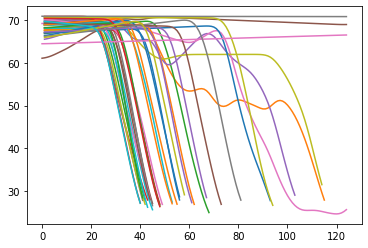

In [72]:
for pos in get_positions_array_end_StereotypedTrials(data):
    plt.plot(pos)
plt.show()

In [ ]:
a=get_positions_array_end_StereotypedTrials(data)

In [ ]:
speed=forwardRunningSpeed(data).compute()

In [ ]:
np.nanmedian(list(speed.values())),np.nanstd(list(speed.values()))

In [ ]:
a=speed.values()